In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Ingest and explore data

In [3]:
#Load the dataset
df = pd.read_csv('heart.csv')

df.head()

#Check if there are duplicate and missing values
print('Duplicate values :' , len(df[df.duplicated()]))
print('Missing values :', df.isnull().sum().sum())

#Extract numerical column and catergorical column
numerical= df.select_dtypes(include=np.number).columns.tolist()

print('There are', len(numerical), 'numerical features:')
print(numerical)

categorical= df.select_dtypes('object').columns.tolist()
print('There are', len(categorical),'categorical features:')
print(categorical)
df[categorical].nunique()

#Remove 0 RestingBP
df = df.drop(df[(df['RestingBP'] == 0)].index)

# Replace zero values with median
col_median = df['Cholesterol'].median()
row = df[df['Cholesterol']==0].index
df.loc[row, 'Cholesterol'] = col_median

df.describe()

Duplicate values : 0
Missing values : 0
There are 7 numerical features:
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
There are 5 categorical features:
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,240.600872,0.233370,136.789531,0.886696,0.552890
std,9.437636,17.999749,54.009298,0.423206,25.467129,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


# Data Proprocessing

In [4]:
# Scaling features
for col in numerical:
    df[col] = MinMaxScaler().fit_transform(df[[col]])

# One hot encoding using pd.get_dummies
categorical= df.select_dtypes('object').columns
df = pd.get_dummies(df, columns=categorical, drop_first=True)  

# Set up X and y variables
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']

# Split the data into training and test samples 30% test data, 70% trainning data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define, train and evaluate models

In [5]:
# Models
dummy = DummyClassifier(strategy='constant',constant=1) #Baseline model
lr = LogisticRegression(solver='liblinear') # Standard logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear')
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=1)
svm= SVC(probability=True)
dt = DecisionTreeClassifier(random_state=42)
rf= RandomForestClassifier()


models = [dummy,lr,lr_l1,lr_l2,knn,svm,dt,rf]

features = X.columns
accuracy = []
f1 = []
roc= []
model_names = ['Dummy',
               'Logistic Regression',
               'L1 regularization',
               'L2 regularization',
               'KNN',
               'svm',
               'Decision Tree',
               'Random forest']

for model in models:
    #Train models
    model.fit(X_train, y_train)
    # Predict target value 
    y_pred = model.predict(X_test)
    # Store accuracy score into lists
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    #store f1 score into lists
    f1.append(round(f1_score(y_test, y_pred), 4))
    # Calculate ROC_AUC score and store into lists
    y_pred_prob = model.predict_proba(X_test)[:,1]
    roc.append(round(roc_auc_score(y_test, y_pred_prob),4))

    #Calculate features importance for tree-based algorithms
    if model == rf:
        rf_feat_imp=pd.DataFrame({'Features': features,'Importance Score':model.feature_importances_})
    if model == dt:
        dt_feat_imp=pd.DataFrame({'Features': features,'Importance Score':model.feature_importances_})
        
    #Calculate features importance for linear algorithms
    if model == lr:
        lr_feat_imp= pd.DataFrame({'Features': features,'Importance Score':model.coef_[-1]})
    if model == lr_l1:
        lr_l1_feat_imp= pd.DataFrame({'Features': features,'Importance Score':model.coef_[-1]})
    if model == lr_l2:
        lr_l2_feat_imp= pd.DataFrame({'Features': features,'Importance Score':model.coef_[-1]})


df_importance = (rf_feat_imp, dt_feat_imp, lr_feat_imp, lr_l1_feat_imp, lr_l2_feat_imp)
for dfs in df_importance:
    dfs.sort_values('Importance Score', ascending=True, inplace=True)


#Print table for the result
results= {'Accuracy':accuracy ,'F1':f1, 'ROC_AUC':roc} 
accuracy_models = pd.DataFrame(results,index=model_names)
accuracy_models.sort_values('Accuracy',ascending=False, inplace=True)

accuracy_models

,Accuracy,F1,ROC_AUC
L2 regularization,0.8768,0.8957,0.9336
Logistic Regression,0.8732,0.8930,0.9334
L1 regularization,0.8696,0.8896,0.9341
Random forest,0.8587,0.8836,0.9267
svm,0.8514,0.8754,0.9281
KNN,0.8261,0.8519,0.8288
Decision Tree,0.7790,0.8063,0.7870
Dummy,0.6123,0.7596,0.5000


# Plot Confusion matrix of all models

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: Co

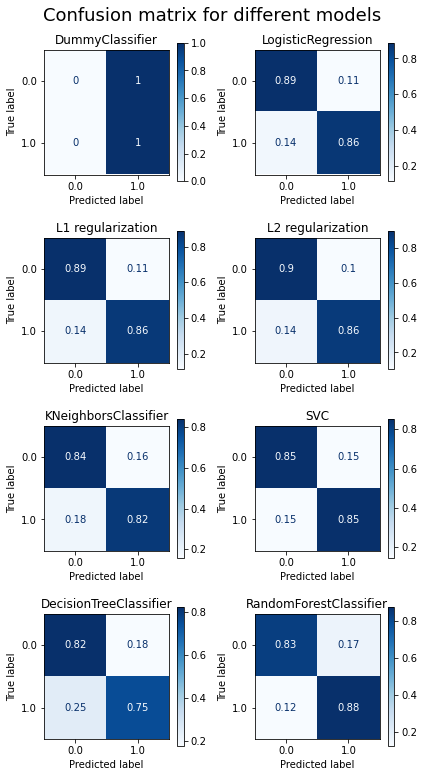

In [6]:
fig, axes = plt.subplots(4,2, figsize=(6,11))
axes = axes.ravel()
for i,(model,name) in enumerate(zip(models,model_names)):
#for model, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(model, 
                          X_test, 
                          y_test, 
                          ax=axes[i], 
                          cmap='Blues',
                         normalize='true')
    
    if name in ['L1 regularization','L2 regularization']:
        axes[i].title.set_text(name)
    else:
        axes[i].title.set_text(type(model).__name__)


plt.suptitle('Confusion matrix for different models',
            fontfamily='sans-serif',
            fontsize=18)
    
plt.tight_layout()
plt.savefig('confusionmatrix.png', dpi=400)
plt.show()

# Plot Feature importance graph

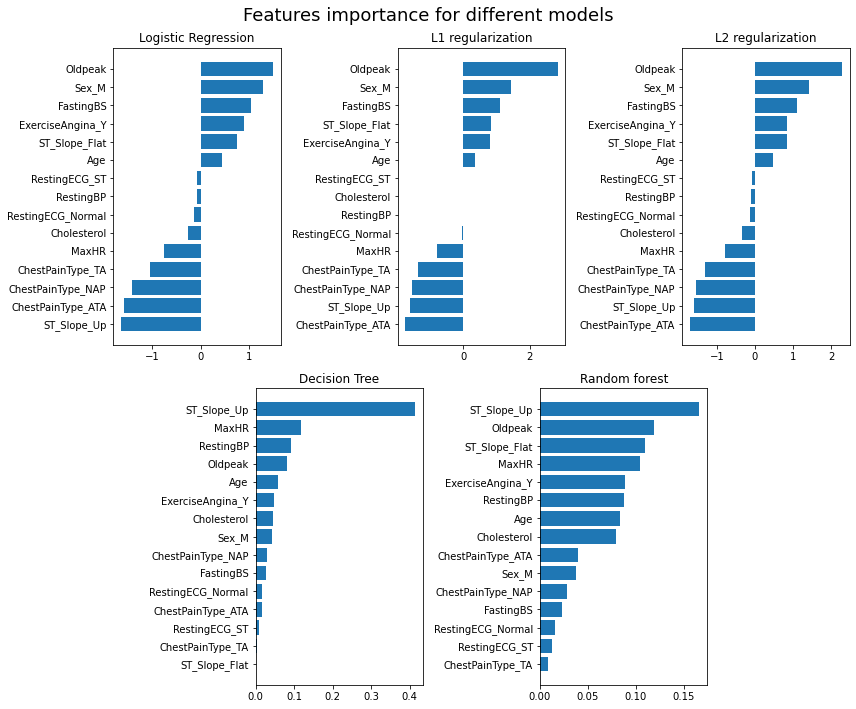

In [7]:
fig = plt.figure(figsize=(12,10))


ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

plt.suptitle('Features importance for different models',
            fontfamily='sans-serif',
            fontsize=18)


ax1.barh(lr_feat_imp['Features'],lr_feat_imp['Importance Score'])
ax1.set_title('Logistic Regression')
ax2.barh(lr_l1_feat_imp['Features'],lr_l1_feat_imp['Importance Score'])
ax2.set_title('L1 regularization')
ax3.barh(lr_l2_feat_imp['Features'],lr_l2_feat_imp['Importance Score'])
ax3.set_title('L2 regularization')
ax4.barh(dt_feat_imp['Features'],dt_feat_imp['Importance Score'])
ax4.set_title('Decision Tree')    
ax5.barh(rf_feat_imp['Features'],rf_feat_imp['Importance Score'])
ax5.set_title('Random forest')


fig.tight_layout()
plt.savefig('featureimportance.png', dpi=400)
plt.show()